# Variance Reduction - Weight Windows

## Creating and utilizing a wight window to accelerate the deep shielding simulations

This example simulates a shield room / bunker with corridor entrance a neutron source in the center of the room with This example implements a single step of the Magic method of weight window generation. 

In this tutorial we shall focus on generating a weight window to accelerate the simulation of particles through a shield.

Weight Windows are found using the MAGIC method and used to accelerate the simulation.

The variance reduction method used for this simulation is well documented in the OpenMC documentation
https://docs.openmc.org/en/stable/methods/neutron_physics.html

The MAGIC method is well described in the original publication
https://scientific-publications.ukaea.uk/wp-content/uploads/Published/INTERN1.pdf

This example has been copied with permission from the neutronics-workshop
https://github.com/fusion-energy/neutronics-workshop


First we import ```openmc``` including ```openmc.lib``` and other packages needed for the example

In [62]:
import time  # used to time the simulation

import openmc
import openmc.lib  # this example makes use of openmc lib to run the simulations

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm  # used for plotting log scale graphs

We create a couple of materials for the simulation

In [63]:
mat_air = openmc.Material(name="Air")
mat_air.add_element("N", 0.784431)
mat_air.add_element("O", 0.210748)
mat_air.add_element("Ar", 0.0046)
mat_air.set_density("g/cc", 0.001205)

mat_concrete = openmc.Material()
mat_concrete.add_element("H",0.168759)
mat_concrete.add_element("C",0.001416)
mat_concrete.add_element("O",0.562524)
mat_concrete.add_element("Na",0.011838)
mat_concrete.add_element("Mg",0.0014)
mat_concrete.add_element("Al",0.021354)
mat_concrete.add_element("Si",0.204115)
mat_concrete.add_element("K",0.005656)
mat_concrete.add_element("Ca",0.018674)
mat_concrete.add_element("Fe",0.00426)
mat_concrete.set_density("g/cm3", 2.3)

materials = openmc.Materials([mat_air, mat_concrete])

Now we define and plot the geometry. This geometry is define by parameters for every width and height. The parameters input into the geometry in a stacked manner so they can easily be adjusted to change the geometry without creating overlapping cells.

In [64]:

width_a = 100
width_b = 200
width_c = 500
width_d = 250
width_e = 200
width_f = 200
width_g = 100

depth_a = 100
depth_b = 200
depth_c = 700
depth_d = 600
depth_e = 200
depth_f = 100

height_j = 100
height_k = 500
height_l = 100

xplane_0 = openmc.XPlane(x0=0, boundary_type="vacuum")
xplane_1 = openmc.XPlane(x0=xplane_0.x0 + width_a)
xplane_2 = openmc.XPlane(x0=xplane_1.x0 + width_b)
xplane_3 = openmc.XPlane(x0=xplane_2.x0 + width_c)
xplane_4 = openmc.XPlane(x0=xplane_3.x0 + width_d)
xplane_5 = openmc.XPlane(x0=xplane_4.x0 + width_e)
xplane_6 = openmc.XPlane(x0=xplane_5.x0 + width_f)
xplane_7 = openmc.XPlane(x0=xplane_6.x0 + width_g, boundary_type="vacuum")

yplane_0 = openmc.YPlane(y0=0, boundary_type="vacuum")
yplane_1 = openmc.YPlane(y0=yplane_0.y0 + depth_a)
yplane_2 = openmc.YPlane(y0=yplane_1.y0 + depth_b)
yplane_3 = openmc.YPlane(y0=yplane_2.y0 + depth_c)
yplane_4 = openmc.YPlane(y0=yplane_3.y0 + depth_d)
yplane_5 = openmc.YPlane(y0=yplane_4.y0 + depth_e)
yplane_6 = openmc.YPlane(y0=yplane_5.y0 + depth_f, boundary_type="vacuum")

zplane_1 = openmc.ZPlane(z0=0, boundary_type="vacuum")
zplane_2 = openmc.ZPlane(z0=zplane_1.z0 + height_j)
zplane_3 = openmc.ZPlane(z0=zplane_2.z0 + height_k)
zplane_4 = openmc.ZPlane(z0=zplane_3.z0 + height_l, boundary_type="vacuum")

outside_left_region = +xplane_0 & -xplane_1 & +yplane_1 & -yplane_5 & +zplane_1 & -zplane_4
wall_left_region = +xplane_1 & -xplane_2 & +yplane_2 & -yplane_4 & +zplane_2 & -zplane_3
wall_right_region = +xplane_5 & -xplane_6 & +yplane_2 & -yplane_5 & +zplane_2 & -zplane_3
wall_top_region = +xplane_1 & -xplane_4 & +yplane_4 & -yplane_5 & +zplane_2 & -zplane_3
outside_top_region = +xplane_0 & -xplane_7 & +yplane_5 & -yplane_6 & +zplane_1 & -zplane_4
wall_bottom_region = +xplane_1 & -xplane_6 & +yplane_1 & -yplane_2 & +zplane_2 & -zplane_3
outside_bottom_region = +xplane_0 & -xplane_7 & +yplane_0 & -yplane_1 & +zplane_1 & -zplane_4
wall_middle_region = +xplane_3 & -xplane_4 & +yplane_3 & -yplane_4 & +zplane_2 & -zplane_3
outside_right_region = +xplane_6 & -xplane_7 & +yplane_1 & -yplane_5 & +zplane_1 & -zplane_4

room_region = +xplane_2 & -xplane_3 & +yplane_2 & -yplane_4 & +zplane_2 & -zplane_3
gap_region = +xplane_3 & -xplane_4 & +yplane_2 & -yplane_3 & +zplane_2 & -zplane_3
corridor_region = +xplane_4 & -xplane_5 & +yplane_2 & -yplane_5 & +zplane_2 & -zplane_3

roof_region = +xplane_1 & -xplane_6 & +yplane_1 & -yplane_5 & +zplane_1 & -zplane_2
floor_region = +xplane_1 & -xplane_6 & +yplane_1 & -yplane_5 & +zplane_3 & -zplane_4

outside_left_cell = openmc.Cell(region=outside_left_region, fill=mat_air)
outside_right_cell = openmc.Cell(region=outside_right_region, fill=mat_air)
outside_top_cell = openmc.Cell(region=outside_top_region, fill=mat_air)
outside_bottom_cell = openmc.Cell(region=outside_bottom_region, fill=mat_air)
wall_left_cell = openmc.Cell(region=wall_left_region, fill=mat_concrete)
wall_right_cell = openmc.Cell(region=wall_right_region, fill=mat_concrete)
wall_top_cell = openmc.Cell(region=wall_top_region, fill=mat_concrete)
wall_bottom_cell = openmc.Cell(region=wall_bottom_region, fill=mat_concrete)
wall_middle_cell = openmc.Cell(region=wall_middle_region, fill=mat_concrete)
room_cell = openmc.Cell(region=room_region, fill=mat_air)
gap_cell = openmc.Cell(region=gap_region, fill=mat_air)
corridor_cell = openmc.Cell(region=corridor_region, fill=mat_air)

roof_cell = openmc.Cell(region=roof_region, fill=mat_concrete)
floor_cell = openmc.Cell(region=floor_region, fill=mat_concrete)

geometry = openmc.Geometry(
    [
        outside_bottom_cell,
        outside_top_cell,
        outside_left_cell,
        outside_right_cell,
        wall_left_cell,
        wall_right_cell,
        wall_top_cell,
        wall_bottom_cell,
        wall_middle_cell,
        room_cell,
        gap_cell,
        corridor_cell,
        roof_cell,
        floor_cell,
    ]
)


Now we plot the geometry and color by materials.

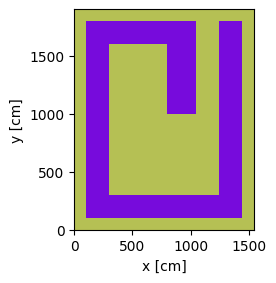

In [65]:

geometry.root_universe.plot(basis='xy', color_by='material') 
plt.savefig('geometry_top_down_view.png', bbox_inches="tight")

Next we create a point source, this also uses the same geometry parameters to place in the center of the room regardless of the values of the parameters.

In [66]:
# location of the point source
source_x = width_a + width_b + width_c * 0.5
source_y = depth_a + depth_b + depth_c * 0.75
source_z = height_j + height_k * 0.5
space = openmc.stats.Point((source_x, source_y, source_z))

angle = openmc.stats.Isotropic()

# all (100%) of source particles are 2.5MeV energy
energy = openmc.stats.Discrete([2.5e6], [1.0])

source = openmc.Source(space=space, angle=angle, energy=energy)
source.particle = "neutron"


Next we create a mesh that encompasses the entire geometry and scores neutron flux

In [67]:
mesh = openmc.RegularMesh().from_domain(geometry)
mesh.dimension = (500, 500, 1)

mesh_filter = openmc.MeshFilter(mesh)
particle_filter = openmc.ParticleFilter('neutron')

flux_tally = openmc.Tally(name="flux tally")
flux_tally.filters = [mesh_filter, particle_filter]
flux_tally.scores = ["flux"]
flux_tally.id = 42  # we set the ID because we need to access this later

tallies = openmc.Tallies([flux_tally])

/home/j/openmc/openmc/mixin.py:70: IDWarning: Another Tally instance already exists with id=42.
  warn(msg, IDWarning)


Creates the simulation settings

In [68]:
settings = openmc.Settings()

settings.run_mode = "fixed source"
settings.source = source
settings.particles = 40000
settings.batches = 5
# no need to write the tallies.out file which saves space and time when large meshes are used
settings.output = {'tallies': False}

Creates and export the model

In [69]:
model = openmc.Model(geometry, materials, settings, tallies)
model.export_to_xml()  # this is necessary as openmc.lib loads up the model.xml file

Now we make use of openmc.lib to control the simulation. Documentation on openmc.lib is here
https://docs.openmc.org/en/stable/pythonapi/capi.html

We also time the simulation so that we can perform the same simulation again with weight windows and try to fine tune the particle so that both simulations take the same time and we are making a fair comparision.

In [70]:
# this helps time the simulation
t0 = time.time()

# first we initialize openmc lib, this reads in the model.xml and material cross sections 
openmc.lib.init()

# This runs openmc with the settings provided earlier
openmc.lib.run()

# End the connection to openmc lib and write out the statepoint file
openmc.lib.finalize()

# End the connection to openmc lib and write out the statepoint file
openmc.lib.finalize()

t1 = time.time()

total = t1-t0

print(f'total time without weight windows {total}s')

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading C13 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/C13.h5
 Reading Na23 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/Na23.h5
 Reading Mg24 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/Mg24.h5
 Reading Mg25 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/Mg25.h5
 Reading Mg26 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/Mg26.h5
 Reading Al27 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/Al27.h5
 Reading Si28 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/Si28.h5
 Reading Si29 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/Si29.h5
 Reading Si30 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/Si30.h5
 Reading K39 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/K39.h5
 Reading K40 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/K40.h5
 Reading K41 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/K41.h5
 Reading Ca40 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/Ca40.h5
 Reading Ca42 from /

Now we want to plot the results of the simulation. We want to do this twice to compare the results so I've written this up as a function that we can call.

In [71]:
def plot_mesh_tally(statepoint_filename, image_filename):

    with openmc.StatePoint(statepoint_filename) as sp:
        flux_tally = sp.get_tally(name="flux tally")

    mesh_extent = mesh.bounding_box.extent['xy']

    # get a slice of mean values on the xy basis mid z axis
    flux_mean = flux_tally.get_reshaped_data(value='mean', expand_dims=True, squeeze=True)#[:, :, 1]
    plt.subplot(1, 2, 1)
    # create a plot of the mean flux values
    plt.imshow(
        flux_mean.T,
        origin="lower",
        extent=mesh_extent,
        norm=LogNorm(),
    )
    plt.title("Flux Mean")


    plt.subplot(1, 2, 2)
    # get a slice of std dev values on the xy basis mid z axis
    flux_std_dev = flux_tally.get_reshaped_data(value='std_dev', expand_dims=True, squeeze=True)# .squeeze()[:, :, 1]
    # create a plot of the flux relative error
    plt.imshow(
        flux_std_dev.T,
        origin="lower",
        extent=mesh_extent,
        norm=LogNorm(),
    )
    plt.title("Flux Std. Dev.")

    plt.savefig(image_filename)

This next section calls the plotting function and saves an image of the mesh tally as no_ww.png

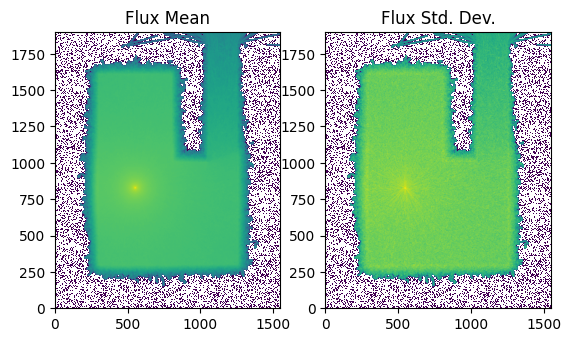

In [72]:
plot_mesh_tally(f'statepoint.{settings.batches}.h5', 'no_ww.png')

Now we want to run the simulation twice. Once to generate weight windows and once to make use of the weight windows. We are going to adjust the number of particles to try and spend the same total amount of computer time as the last simulation and make this a fair test. This might require some adaption of the particles as the simulation is set up for my laptop.

In [73]:
# this helps time the simulation
t0 = time.time()

# first we initialize openmc lib, this reads in the model.xml and material cross sections 
openmc.lib.init()

# Now we find the mesh tally that will be used for creating the weight windows 
# This ID of 42 matches the tally ID we set earlier
# At this point the tally is empty.
tally = openmc.lib.tallies[42]

# We create a weight window object from the empty tally. 
wws = openmc.lib.WeightWindows.from_tally(tally)

# We are running a fraction of particles of the original simulation as we want
# to take less simulation time for the first run and leave some simulation time
# for the run with weight windows.
openmc.lib.settings.particles = 6000

# This runs openmc with the settings provided earlier
openmc.lib.run()

# The tally now contains meaningful information.
# So we can update the weight windows from the tally.
# This uses the MAGIC method
wws.update_magic(tally)

# Now we enable weight window usage, previously this was set to False by default
openmc.lib.settings.weight_windows_on = True

# As the particles are now splitting the number of particles run per second
# will be significantly lower. Therefore we will reduce the number of particles
# so that the simulation runs in  reasonable amount of time
openmc.lib.settings.particles = 300

# Now we run the simulation again, this time with the weight windows in use
openmc.lib.run()

# End the connection to openmc lib and write out the statepoint file
openmc.lib.finalize()

t1 = time.time()

total = t1-t0

print(f'total time without weight windows {total}s')

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading C13 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/C13.h5
 Reading Na23 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/Na23.h5
 Reading Mg24 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/Mg24.h5
 Reading Mg25 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/Mg25.h5
 Reading Mg26 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/Mg26.h5
 Reading Al27 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/Al27.h5
 Reading Si28 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/Si28.h5
 Reading Si29 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/Si29.h5
 Reading Si30 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/Si30.h5
 Reading K39 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/K39.h5
 Reading K40 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/K40.h5
 Reading K41 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/K41.h5
 Reading Ca40 from /home/j/nndc-b8.0-hdf5/endfb-viii.0-hdf5/neutron/Ca40.h5
 Reading Ca42 from /

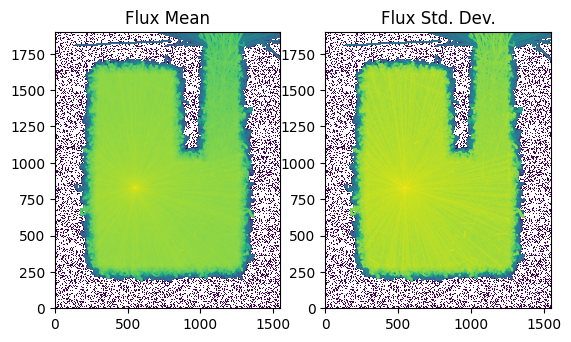

In [74]:
plot_mesh_tally(f'statepoint.{settings.batches}.h5', 'ww.png')

On my laptop both simulations took 20 seconds to complete but the resulting flux map from the simulation with weight windows shows neutrons got further through the geometry.

The weight windows allow the computer to spend a larger proportion of time simulating valuable neutrons that have reached regions of low neutron flux.